# 텐서플로우를 이용한 사진 분류 딥러닝 모델 만들기
---
파이썬(Python)의 기계학습 라이브러리는 주로 텐서플로우(TensorFlow)나 파이토치(PyTorch)가 이용됩니다. 최근에는 파이토치의 점유율이 조금 더 높아 보이지만, 예전에는 텐서플로우의 인기가 더 많았던 때가 있기 때문에 각각의 라이브러리를 이용한 문서는 쉽게 찾아볼 수 있지요. 이번에는 그중에서 텐서플로우를 이용해서 딥러닝 모델 구현을 해 보려고 합니다. 말과 사람을 구분하는 작업이예요.  
</p></br></br>
이번 작업에서 사용하는 데이터셋은 horse or human 데이터인데요, <a href="https://laurencemoroney.com/datasets.html">Laurence Moroney</a> 에서 제공하는 데이터입니다. CG로 생성된 300*300px 크기의 말 또는 사람이 들어있는 컬러 이미지 데이터이며, 다양한 포즈와 배경이 있어서 일반적인 기계학습 모델은 분류가 원활하지 않을 수도 있습니다.  
</p></br></br>
그리고, 딥러닝 모델을 구현할 라이브러리는 텐서플로우를 사용하도록 하겠습니다. 기본적인 CNN(Convolutional Neural Network) 모델을 사용할 예정이며, 학습과 분류 과정을 모두 수행해 보도록 하겠습니다.  
</p></br></br>

horse: 500
human: 527


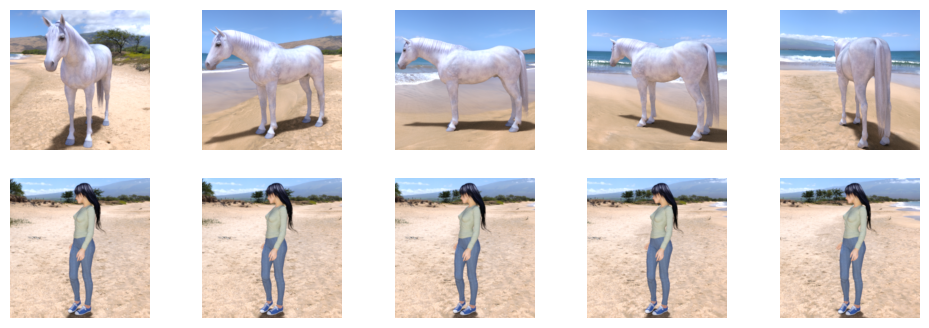

In [1]:
# 패키지 불러오기
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 데이터셋 경로 지정
train_horse_dir = './dataset/horse-or-human/train/horses'
train_human_dir = './dataset/horse-or-human/train/humans'

# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

# 학습 데이터의 개수 확인
print('horse:', len(train_horse_names))
print('human:', len(train_human_names))

# 데이터 미리보기
fig, axes = plt.subplots(2,5, figsize=(12,4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.show()

</p></br></br>

## 딥러닝 모델 설계하기
---
CNN 모델은 기본적으로 데이터의 특징을 추출하는 Convolutional Layer의 집합으로 이루어져 있습니다. 관련 기술문서를 보면, 작은 크기의 Convolutional Layer를 이용해서 합성곱 연산을 한다는 설명을 볼 수 있는데... 이걸 정확하게 이해하려면 높은 수준의 수리통계적, 컴퓨터공학적 지식이 요구되므로 초보 수준에서는 Convolutional Layer를 거칠수록 데이터의 크기는 줄어들지만 채널이 늘어난다고 이해해 두시면 되겠습니다.  
</p></br></br>

In [2]:
# 모델 설계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

</p></br></br>
이후에는, 모델이 이용할 손실함수(loss function, 모델과 실제의 값 차이를 계산하는 함수)와 최적화함수(optimizer, 손실함수를 최소화하는 연산 방법)를 설정해 줍니다. 저는 이번 모델에 loss 설정은 binary crossentropy를 이용했고, optimizer는 Adam을 이용했습니다.  
</p></br></br>

In [3]:
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

</p></br></br>
그리고, 파이썬 딥러닝 모델에 입력할 이미지 데이터 전처리를 진행해 줍니다. 흔히 사용하는 이미지 파일은 각 픽셀별로 0~255 사이의 밝기 값을 가지므로, 모든 값을 255로 나누어 0~1 사이의 값으로 조정해줍니다. 이렇게 하면, 딥러닝 모델이 요구하는 0~1 scale을 유지할 수 있게 됩니다.  
</p></br></br>
그리고, 이미지 크기는 300*300px로 조절한 뒤 이진 분류를 할 수 있도록 설정해 줍니다. 이 과정은 keras에서 제공하는 ImageDataGenerator 클래스를 이용합니다. ImageDataGenerator는 이미지가 위치한 경로를 지정해 주면, 그 안에 들어있는 폴더에 따라 class를 자동으로 입력해 주는 편리한 기능입니다. 이번에 사용하는 데이터셋은 train, validation 폴더 안에 각각 horses, humans 폴더로 이미지를 분리해 두었기 때문에 별도 데이터 입력을 하지 않아도 됩니다.  
</p></br></br>

In [4]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255)

# train set
train_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/train/',
  target_size=(300, 300),  # 해상도 조절
  batch_size=128,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/validation/',
  target_size=(300, 300),
  batch_size=128,
  class_mode='binary'
)

# 모델 학습
history = model.fit(
  train_generator,
  steps_per_epoch=8,
  epochs=15,
  verbose=1
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15
8/8 [==============================] - 25s 3s/step - loss: 0.6784 - accuracy: 0.6285
Epoch 2/15
8/8 [==============================] - 30s 4s/step - loss: 0.3789 - accuracy: 0.8198
Epoch 3/15
8/8 [==============================] - 28s 3s/step - loss: 0.1710 - accuracy: 0.9288
Epoch 4/15
8/8 [==============================] - 28s 3s/step - loss: 0.1982 - accuracy: 0.9210
Epoch 5/15
8/8 [==============================] - 34s 4s/step - loss: 0.0995 - accuracy: 0.9658
Epoch 6/15
8/8 [==============================] - 29s 4s/step - loss: 0.0849 - accuracy: 0.9700
Epoch 7/15
8/8 [==============================] - 29s 3s/step - loss: 0.0456 - accuracy: 0.9844
Epoch 8/15
8/8 [==============================] - 27s 3s/step - loss: 0.0349 - accuracy: 0.9867
Epoch 9/15
8/8 [==============================] - 31s 4s/step - loss: 0.0323 - accuracy: 0.9863
Epoch 10/15
8/8 [==============================] - 28

</p></br></br>

## 모델 평가
---
model.fit 함수를 이용해서 모델 학습까지 끝낸 뒤에는, history 변수에 저장된 정보를 이용해 학습 중 loss와 accuracy의 변화를 확인할 수 있습니다. 이상적인 모델과 학습 데이터를 사용한다고 가정하면 loss가 급격히 줄어들다 학습이 끝나기 조금 전 미소값으로 수렴하는 꼴이, accuracy가 급격하게 늘어나다 학습이 끝나기 조금 전 100%에 가까운 값으로 수렴하는 꼴이 되어야 합니다.  
</p></br></br>

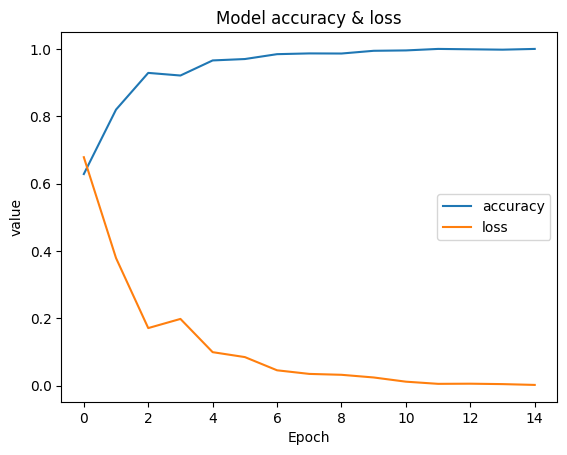

In [5]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

</p></br></br>
위 그래프를 살펴보면, 학습 과정에서 과적합(overfitting)이 의심되지만 이외의 큰 문제가 발생하지는 않은 것으로 보입니다. 그러면 미리 만들어 두었던 테스트용 데이터(valid_generator)를 이용해서 다른 데이터를 분류하는데도 원활하게 동작할 수 있는지 알아봐야겠지요. model.evaluate 함수를 이용해서 데이터를 입력해 주도록 합시다.  
</p></br></br>

In [6]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

2/2 [==============================] - 3s 1s/step - loss: 2.4849 - accuracy: 0.8320
test loss, test acc: [2.4849119186401367, 0.83203125]


</p></br></br>
평가 결과를 살펴보면 loss는 2.48, accuracy는 83.20으로 나타난걸 확인할 수 있습니다. 학습 데이터와 테스트 데이터가 다르기 때문에 위 그래프에서 보인 loss와 accuracy랑은 다른 결과를 확인할 수 있는데요, 모델 학습에 직접적으로 참여하지 않은 데이터를 이용했기 때문에 정확도가 약간 떨어지는 것이 정상입니다. 하지만, 80% 내외의 정확도는 특수한 상황을 제외하고는 높다고 보기 어려운 수치이므로 이 모델은 수정을 하면 성능을 개선할 수 있는 여지가 크다고 볼 수 있겠네요.  
</p></br></br>

## 외부 데이터를 이용한 테스트
---
이제는 기존에 준비한 데이터가 아니라, 새로운 데이터를 이용해서 테스트를 해 보는 상황을 가정해 봅시다. 구글에 말 또는 사람 사진을 아무거나 검색해 다운로드한 뒤, 이 파이썬 딥러닝 모델이 어떻게 분류하는지를 살펴보는 과정입니다. 저는 무작위 구도와 크기의 말 사진 3장과 사람 사진 2장을 준비했습니다. 해당 사진은 openCV를 이용해서 300*300px 사이즈로 조절한 뒤 0~1 범위의 값으로 변환해 주었습니다.  
</p></br></br>

In [7]:
# 이미지 전처리
dlist = './dataset/horse-or-human/test/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300,300)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse1.jpg', 'horse2.webp', 'horse3.jpg', 'human1.jpg', 'human2.jpg']
1/1 [==============================] - 0s 210ms/step
[[False]
 [False]
 [ True]
 [False]
 [ True]]


</p></br></br>
모델을 학습시킬 때, ImageDataGenerator를 이용해 라벨링을 했으므로, 각 클래스는 ABC 오름차순으로 매겨져 있습니다. 이 때, horses는 0, humans는 1로 설정됩니다. 이를 미루어보면, 이번에 분류를 시도한 각 사진은 차례대로 horse, horse, human, horse, human으로 예측한 것을 확인할 수 있습니다.5개 중에서 3개를 맞췄네요.  
</p></br></br>
이렇게 사람과 말 사진을 분류할 수 있는 파이썬 모델을 구성해 보았는데요, 이 모델은 최적화를 통해서 정확도를 올리는 방법과 컷오프를 조절해서 특정 분류에 조금 더 민감하게 반응하는 방법 등을 활용해서 개선을 해볼 수 있습니다.